In [1]:
# General libraries
import numpy as np
from scipy.stats import norm
import os

# Parallelisation libraries
from joblib import Parallel, delayed

# Module functions
# import ximinf.selection_effects as se
import ximinf.generate_sim as gsim
import ximinf.nn_inference as nninf
import ximinf.nn_test as nnte
import ximinf.nn_train as nntr

# Plot libraries
import matplotlib.pyplot as plt
import corner

from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
num_threads = os.cpu_count()
print(f"Number of threads: {num_threads}")

Number of threads: 48


In [3]:
# -------- User parameters --------

N = 1 # Number of samples 100_000
M = 1000 # Number of SNe per sample #3_000

# ---------------------------------

params = {
    'mabs': -19.3,
    'alpha_low': -0.271,
    'alpha_high': -0.083,
    'beta': 3.31,
    'gamma': 0.175,
    'sigma_int': 0.15,
}

columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'localcolor', 'localcolor_err', 'mass', 'mass_err', 'prompt', 'z']

n_realisation = 200

N_total = N*n_realisation

print("Running parallel simulations...")

results = Parallel(n_jobs=max(1,min(N_total//20, num_threads-2)))(
    delayed(gsim.simulate_one)(
        params,
        z_max=0.06,
        M=M,
        cols=columns,
        N=N_total,
        i=i
    )
    for i in range(N_total)
)


print("... done")

Running parallel simulations...
... doneon 200/200


In [4]:
# Jax libraries
import jax
import jax.numpy as jnp

In [5]:
# Try GPU backends in priority order
gpu = None
for backend in ("METAL", "cuda", "gpu"):
    try:
        devs = jax.devices(backend)
    except RuntimeError:
        continue
    if devs:
        gpu = devs[0]
        break

# Fallback
cpu = jax.devices("cpu")[0]

# Use GPU if found
if gpu=='cuda':
    nntr.print_gpu_memory()
    device = gpu 
elif gpu is not None:
    device = gpu
else:
    device = cpu
    
jax.default_device(device)
    
backend = jax.default_backend()
print(backend)

gpu


In [6]:
key = jax.random.PRNGKey(42)

In [7]:
data_dict = {col: np.zeros((N_total, M), dtype=np.float32) for col in columns}

for i, sim_data in enumerate(results):  # sim_data is just the dict returned by simulate_one
    for col, arr in sim_data.items():   # arr is a list of length M
        data_dict[col][i, :] = arr   # fill row i

## Load NN

In [8]:
# Parameters
models_per_group, models_config = nninf.load_autoregressive_nn('../data/NNs/nn_model_priors_M1000_z_0_06')

In [9]:
z = data_dict['z']
magobs = data_dict["magobs"]      # (N,M)
mask = magobs != 0           # (N,M)

In [10]:
# Take care to not run the correction twice
mu_planck18, magobs_corr = nntr.rm_cosmo(z, magobs)

data_dict['magobs'] = magobs_corr

In [11]:
# Make a copy to avoid in-place modification
columns_select = ['magobs', 'magobs_err', 'c', 'c_err','x1', 'x1_err', 'localcolor', 'localcolor_err']
data_norm = {k: data_dict[k].copy() for k in columns_select}

data_stats = models_config['shared']['data_stats']

for col, arr in data_norm.items():
    mu = data_stats[col]['mu']
    sigma = data_stats[col]['sigma']

    if col == 'magobs':
        # mask zeros
        mask = arr != 0.0
        data_norm[col] = arr.at[mask].set((arr[mask] - mu) / sigma)
    else:
        data_norm[col] = (arr - mu) / sigma

In [12]:
for model_g in models_per_group:
    model_g.eval()  # disable dropout, etc.

global_param_names = models_config['shared']['global_param_names']
print(f"Parameters : {global_param_names}")

param_groups = models_config['shared']['param_groups']

Parameters : ['mabs', 'beta', 'alpha_low', 'alpha_high', 'gamma', 'sigma_int']


In [13]:
# ========== Set priors ==========
ranges = {
    'mabs': (-21, -18), #(-19.5, -19.0),
    'alpha_low': (-0.5,0), #(-0.5, -0.0),
    'alpha_high': (-0.3,0.2), #(-0.5, -0.0),
    'beta': (2.5,4), #(2.0, 4.0),
    'gamma': (-0.1,0.4), #(0.0, 0.3)
    'sigma_int': (0.0, 0.3),
}

types = {
    'mabs': 'gaussian',         # Uniform in [-21, -18]
    'alpha_low': 'gaussian',
    'alpha_high': 'gaussian',
    'beta': 'gaussian',
    'gamma': 'gaussian',
    'sigma_int': 'half-gaussian',  # Positive, includes zero
}

priors = {name: {'range': np.array(ranges[name], dtype=np.float32), 'type': types[name]}
          for name in ranges.keys()}

if 'mabs' in priors:
    priors['mabs']['range'] += 19.3


In [14]:
param_stats = models_config['shared']['param_stats']

normalized_priors = {}

for name, prior in priors.items():
    mu = param_stats[name]['mu']
    sigma = param_stats[name]['sigma']

    norm_range = (prior['range'] - mu) / sigma
        
    normalized_priors[name] = {
        'range': norm_range,
        'type': prior['type']  # type stays unchanged
    }

theta_init = jnp.asarray([-19.35+19.3, 3.2, -0.3, -0.1, 0.15, 0.15])
theta_init_dict = {name: theta_init[i] for i, name in enumerate(global_param_names)}
theta_init_normed_dict = nntr.normalize(theta_init_dict, param_stats)
theta_init_normed = jnp.array([theta_init_normed_dict[name] for name in global_param_names])

In [15]:
# Convert each column to a 1D array and concatenate into shape (M*C,)
# Prepare inference arrays
data_arrays = [data_norm[col] for col in columns_select]  # list of (M,)
n_cols = len(columns_select)

# Stack along last axis to get shape (M, n_cols)
data_stacked = jnp.stack(jnp.asarray(data_arrays), axis=-1)  

# Flatten and add batch dimension: (1, M * n_cols)
data_concat_infer = data_stacked.reshape(N_total, M * n_cols)

# Concatenate features + mask
inputs_infer = jnp.concatenate([data_concat_infer, jnp.asarray(mask).reshape(N_total,M)], axis=-1)

print(inputs_infer.shape)

(200, 9000)


In [16]:
# ========== MCMC Sampling ==========

# ----------------------------
# Precompute parameter indices
# ----------------------------

group_names_list = []
for g in param_groups:
    if isinstance(g, str):
        group_names_list.append([g])  # wrap single parameter in a list
    else:
        group_names_list.append(g)  
        
visible_indices, group_indices = nnte.preprocess_groups(param_groups, global_param_names)

n_pull = min(200, N_total)

n_points = 100
post_pull = jnp.zeros((n_pull, n_points, len(global_param_names)))

print("Launch MCMCs ...")
for i in range(n_pull):
    print(f'Sample {i+1}/{n_pull}', end='\r')

    def log_post(theta):
        # Use the new grouped log-prob function
        return nnte.log_prob_fn_groups(
            theta,
            models_per_group,  # list of models per group
            inputs_infer[i,:],
            normalized_priors,
            visible_indices,
            group_indices,
            group_names_list
        )
    
    # Run MCMC
    
    key, samples = nnte.sample_posterior(
        log_post,
        n_warmup=100,
        n_samples=n_points,
        init_position=theta_init_normed,
        rng_key=key
    )

    post_pull = post_pull.at[i, :, :].set(samples)
    
print("...finished")

Launch MCMCs ...
...finished200


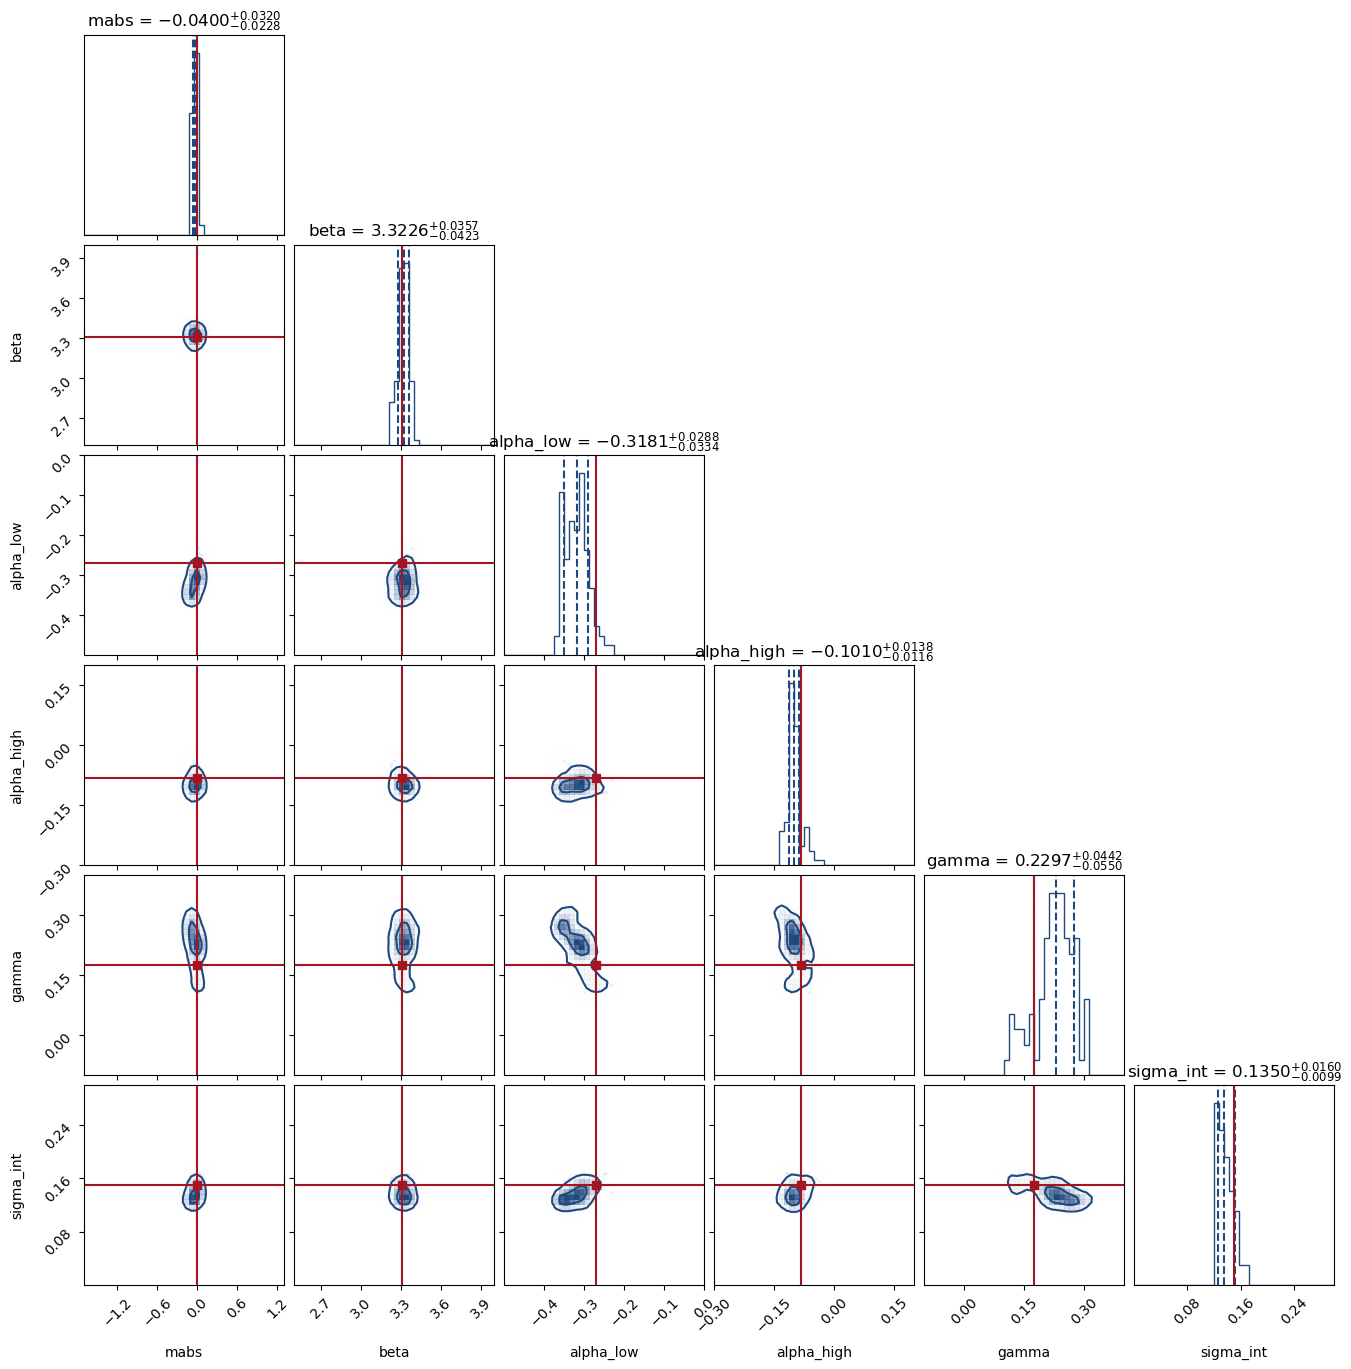

In [18]:
truths = np.array([params[name] for name in global_param_names])
truths[0]+=19.3
post = post_pull[0,:,:]

# post has shape (n_samples, n_params)
n_points, n_params = post.shape

# Convert post from array to dict with column names
post_dict = {name: post[:, i] for i, name in enumerate(global_param_names)}

# Unnormalize each parameter
post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

# Convert back to array for plotting
post_unnormed = jnp.stack([post_unnormed_dict[name] for name in global_param_names], axis=1)

# Now post_unnormed[:, i] contains the real-scale parameters
x = post_unnormed[:, 0]

ranges_from_priors = [
    (float(priors[name]['range'][0]), float(priors[name]['range'][1]))
    for name in global_param_names
]

fig = corner.corner(
    np.array(post_unnormed),
    labels=global_param_names,
    range=ranges_from_priors,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],      # 1D marginal: 1σ
    levels=[0.393469, 0.864665],     # 2D contours: 1σ, 2σ
    show_titles=True,
    title_fmt=".4f",
    bins=40,
    smooth=1.0,
    color="#1F487E",
    truth_color="#A31621", 
    truth_alpha=0.8
)

plt.savefig("./corner.png",dpi=150)
plt.show()

In [19]:
post_pull_unnormed = []

for c in range(n_pull):
    post = post_pull[c]  # (n_samples, n_params)

    post_dict = {
        name: post[:, i]
        for i, name in enumerate(global_param_names)
    }

    post_unnormed_dict = nntr.unnormalize(post_dict, param_stats)

    post_unnormed = jnp.stack(
        [post_unnormed_dict[name] for name in global_param_names],
        axis=1
    )

    post_pull_unnormed.append(post_unnormed)

post_pull_unnormed = jnp.stack(post_pull_unnormed, axis=0)


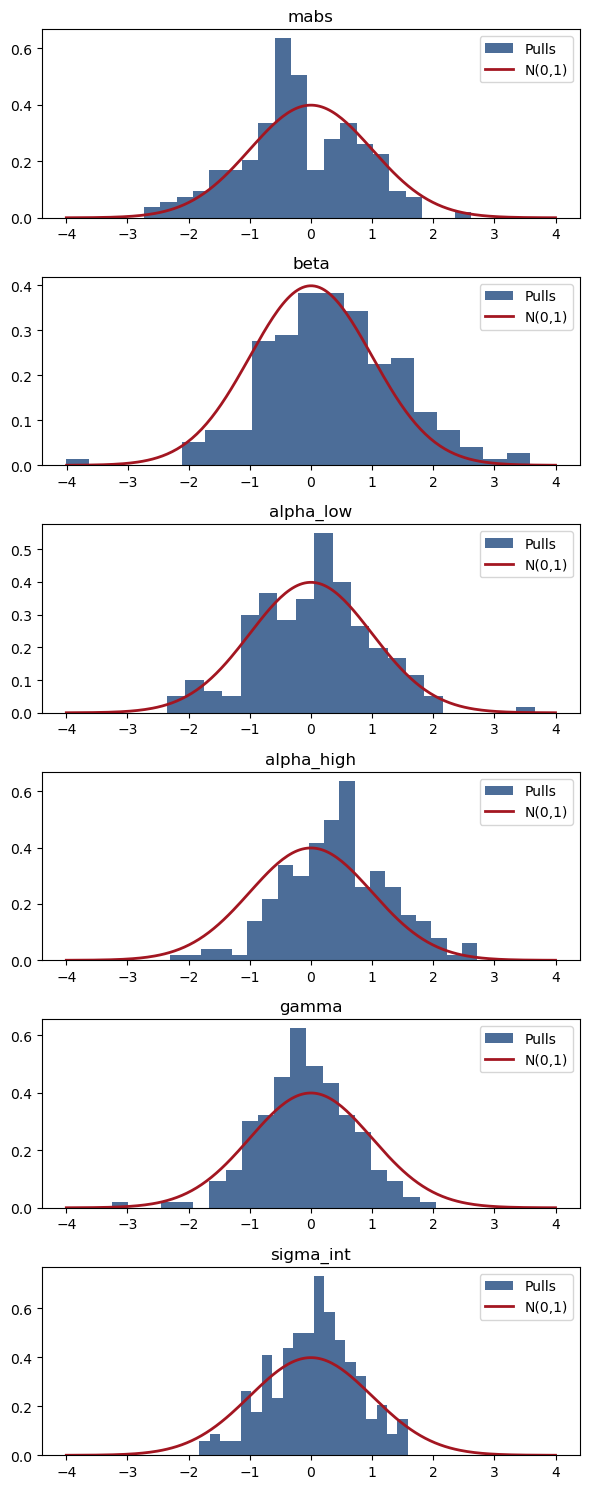

In [20]:
post_pull_mean = jnp.mean(post_pull_unnormed, axis=1)
post_pull_std = jnp.std(post_pull_unnormed, axis=1)
pull = (post_pull_mean - truths)/post_pull_std

fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        pull[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Pulls",
    )

    # Standard normal curve
    x = np.linspace(-4, 4, 200)
    pdf = norm.pdf(x, loc=0, scale=1)
    ax.plot(x, pdf, color="#A31621", linewidth=2, label="N(0,1)")

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('pull.png', dpi=150)
plt.show()


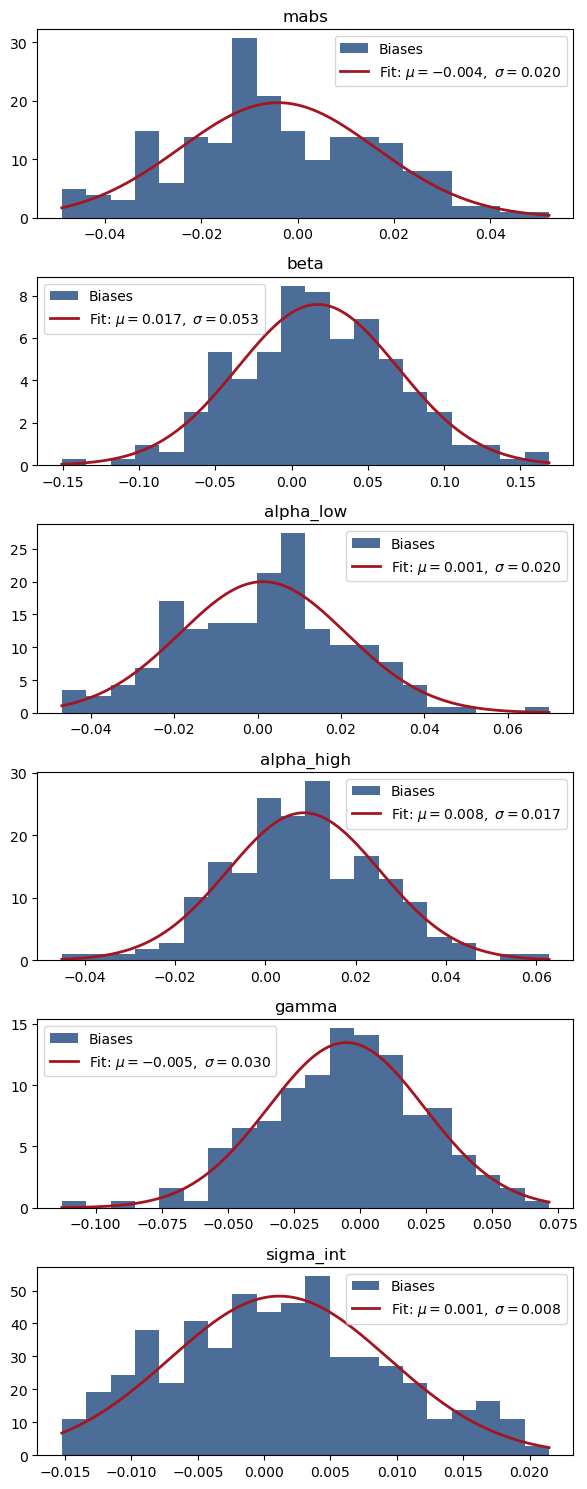

In [21]:
bias = (post_pull_mean - truths)

fig, axes = plt.subplots(
    n_params,
    1,
    figsize=(6, 2.5 * n_params),
    sharex=False,
)

# Make axes iterable even if n_params == 1
axes = np.atleast_1d(axes)

for i, ax in enumerate(axes):
    # Histogram of pulls
    ax.hist(
        bias[:, i],
        bins=20,
        density=True,
        color="#1F487E",
        alpha=0.8,
        label="Biases",
    )

    # Fit Gaussian to samples
    mu_hat, sigma_hat = norm.fit(bias[:, i])

    # Plot fitted Gaussian
    x = np.linspace(bias[:, i].min(), bias[:, i].max(), 400)
    pdf_fit = norm.pdf(x, loc=mu_hat, scale=sigma_hat)
    ax.plot(
        x,
        pdf_fit,
        color="#A31621",
        linewidth=2,
        label=fr"Fit: $\mu={mu_hat:.3f},\ \sigma={sigma_hat:.3f}$",
    )

    ax.set_title(global_param_names[i])
    ax.legend()

plt.tight_layout()
plt.savefig('bias.png', dpi=150)
plt.show()
